## Target: Ensure Speculative Decoding keeps sampling distribution unchanged

## 0. Functions

In [1]:
import os
import sys
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM
from models import NaiveWrapper, SDWrapper, SSM_Eagle
from models.utils import TreeDynamicCache, invert_mask
from copy import deepcopy

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

/home/nctu/envs/eagle/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
@torch.no_grad()
def prefill(model, input_ids, logits_warper, do_sample, llm_past_key_values, ssm_past_key_values):
    # prefill LLM
    outputs = model.llm(input_ids, past_key_values=llm_past_key_values, output_hidden_states=True)
    next_token_logits = outputs.logits[:, -1:, :].clone()
    hidden_states = outputs.hidden_states[-1].clone()
    del outputs
    
    # return hidden_states, next_token_logits
    next_tokens = model._sample_token(next_token_logits, logits_warper, do_sample)
    input_ids = torch.cat([input_ids, next_tokens], dim=-1)
    
    # prefill SSM
    _ = model._speculate(input_ids, hidden_states, ssm_past_key_values)
    ssm_past_key_values.crop(input_ids.shape[1]-1-1)

    return hidden_states[:, -1:], input_ids
    # return hidden_states, input_ids

@torch.no_grad()
def sample_llm(model, input_ids, logits_warper, do_sample, llm_past_key_values, tokens=1):
    org_input_len = input_ids.shape[1]
    prev_llm_kv_len = llm_past_key_values.get_seq_length()
    
    for _ in range(tokens):
        outputs = model.llm(input_ids[:, -1:], past_key_values=llm_past_key_values)
        
        next_token_logits = outputs.logits[:, -1:, :].clone()
        del outputs
        
        next_tokens = model._sample_token(next_token_logits, logits_warper, do_sample)
        input_ids = torch.cat([input_ids, next_tokens], dim=-1)
        
    # crop kv-cache
    llm_past_key_values.crop(prev_llm_kv_len)
    
    return input_ids[:, org_input_len:org_input_len+tokens]

@torch.no_grad()
def sample_sd(model, hidden_states, input_ids, logits_warper, do_sample, llm_past_key_values, ssm_past_key_values, tokens=1):
    org_input_len = input_ids.shape[1]
    prev_llm_kv_len = llm_past_key_values.get_seq_length()
    prev_ssm_kv_len = ssm_past_key_values.get_seq_length()
    
    while input_ids.shape[1] - org_input_len < tokens:
        root = model._speculate(input_ids, hidden_states, ssm_past_key_values)
        
        # * tree decoding
        prev_kv_len = llm_past_key_values.get_seq_length()
        outputs = model._tree_decoding(root, llm_past_key_values, position_offset=input_ids.shape[1]-1, device=input_ids.device, dtype=hidden_states.dtype)
        
        next_token_logits = outputs.logits
        hidden_states = outputs.hidden_states[-1].clone()
        del outputs
        
        # * verify
        sampled_tokens, hidden_indices, _ = model._verify(
                                            root, next_token_logits, 
                                            logits_warper,
                                            do_sample
                                        )

        sampled_tokens = sampled_tokens.to(input_ids.device)
        hidden_indices = hidden_indices.to(hidden_states.device)
        
        input_ids = torch.cat([input_ids, sampled_tokens], dim=-1)
        hidden_states = hidden_states[:, hidden_indices].clone()
        llm_past_key_values.reorder_cache_with_offset(hidden_indices, offset=prev_kv_len, dim=2)
    
    # crop kv-cache
    llm_past_key_values.crop(prev_llm_kv_len)
    ssm_past_key_values.crop(prev_ssm_kv_len)
    
    return input_ids[:, org_input_len:org_input_len+tokens]

# @torch.no_grad()
# def sample_llm_custom_mask(model, input_ids, logits_warper, do_sample, llm_past_key_values, tokens=1):
#     org_input_len = input_ids.shape[1]
#     prev_llm_kv_len = llm_past_key_values.get_seq_length()
    
#     for _ in range(tokens):
#         position_ids = torch.tensor([input_ids.shape[1]-1], dtype=torch.long).unsqueeze(0).to(input_ids.device)
#         attention_mask = torch.ones_like(input_ids).unsqueeze(0).unsqueeze(0).to(input_ids.device)
#         outputs = model.llm(input_ids[:, -1:], past_key_values=llm_past_key_values, position_ids=position_ids, attention_mask=invert_mask(attention_mask, torch.float16)) 
        
#         next_token_logits = outputs.logits[:, -1:, :].clone()
#         del outputs
        
#         next_tokens = model._sample_token(next_token_logits, logits_warper, do_sample)
#         input_ids = torch.cat([input_ids, next_tokens], dim=-1)
        
#     # crop kv-cache
#     llm_past_key_values.crop(prev_llm_kv_len)
    
#     return input_ids[:, org_input_len:org_input_len+tokens]

## 1. Initialize model

In [3]:
device = "auto"
dtype = torch.float16
llm_path = "meta-llama/Llama-2-7b-chat-hf"
ssm_path = "/home/nctu/checkpoints/eagle/d1/l1ce/fp32/model_20/"

# load tokenizer
tokenizer = AutoTokenizer.from_pretrained(llm_path, use_fast=False)

# load LLM
llm = AutoModelForCausalLM.from_pretrained(
    llm_path, 
    torch_dtype=dtype,
    low_cpu_mem_usage=True,
    device_map=device,
)

# load SSM
draft_config = deepcopy(llm.config)
draft_config.num_hidden_layers = 1

ssm = SSM_Eagle.from_pretrained(
    ssm_path,
    config=draft_config,
    sampling_method='greedy',
    eos_token_id=tokenizer.eos_token_id,
    torch_dtype=dtype,
).to(llm.model.layers[-1].self_attn.q_proj.weight.device)

# set sd_model
model = SDWrapper()
model.set_tokenizer(tokenizer)
model.set_llm(llm)
model.set_ssm(ssm)
_ = model.eval()

Loading checkpoint shards: 100%|██████████| 2/2 [00:03<00:00,  1.52s/it]


## 2. Decide how the model sample tokens.

In [4]:
# input message
system_prompt = "You are a helpful, respectful and honest assistant. Always answer as helpfully as possible, while being safe.  Your answers should not include any harmful, unethical, racist, sexist, toxic, dangerous, or illegal content. Please ensure that your responses are socially unbiased and positive in nature.\n\nIf a question does not make any sense, or is not factually coherent, explain why instead of answering something not correct. If you don't know the answer to a question, please don't share false information."
input_message = "What's the best way to start learning a new language?"
messages = [
    {"role": "system", "content": system_prompt},
    {"role": "user", "content": input_message},
]

temperature = 1.5
top_p = None#0.9
top_k = None#0
do_sample = True

logits_warper = (
    model._get_logits_warper(
        temperature=temperature, 
        top_p=top_p, 
        top_k=top_k,
    ) if do_sample else None
)

In [5]:
llm_past_key_values = TreeDynamicCache()
ssm_past_key_values = TreeDynamicCache()
input_ids = tokenizer.apply_chat_template(messages, tokenize=True, add_generation_prompt=True, return_tensors="pt").cuda()
# msg = tokenizer.apply_chat_template(messages, tokenize=False) + " "
# input_ids = tokenizer(msg, return_tensors="pt")["input_ids"].cuda()

prefill_hidden_states, input_ids = prefill(model, input_ids, logits_warper, do_sample, llm_past_key_values, ssm_past_key_values)

# Test
print(llm_past_key_values.get_seq_length(), ssm_past_key_values.get_seq_length())
print(tokenizer.decode(input_ids[0], skip_special_tokens=True))
test = sample_llm(model, input_ids, logits_warper, do_sample, llm_past_key_values, tokens=5)
# test = sample_llm_custom_mask(model, input_ids, logits_warper, do_sample, llm_past_key_values, tokens=5)
# test = sample_sd(model, prefill_hidden_states, input_ids, logits_warper, do_sample, llm_past_key_values, ssm_past_key_values, tokens=5)
print("Test tokens:", tokenizer.batch_decode(test.squeeze(0), clean_up_tokenization_spaces=True))

151 150
[INST] <<SYS>>
You are a helpful, respectful and honest assistant. Always answer as helpfully as possible, while being safe.  Your answers should not include any harmful, unethical, racist, sexist, toxic, dangerous, or illegal content. Please ensure that your responses are socially unbiased and positive in nature.

If a question does not make any sense, or is not factually coherent, explain why instead of answering something not correct. If you don't know the answer to a question, please don't share false information.
<</SYS>>

What's the best way to start learning a new language? [/INST] 
Test tokens: ['Great', 'question', '!', 'There', 'are']


## 3. Repeatedly sample tokens to obtain distribution

In [6]:
# Configurations
rep = 1000#500#1000
comapre_tokens = 6
samples_cnt_arr = [ torch.zeros(comapre_tokens, tokenizer.vocab_size) for _ in range(2) ]

for _ in tqdm(range(rep)):
    samples = [None] * len(samples_cnt_arr)
    samples[0] = sample_llm(model, input_ids, logits_warper, do_sample, llm_past_key_values, tokens=comapre_tokens)
    # samples[1] = sample_llm_custom_mask(model, input_ids, logits_warper, do_sample, llm_past_key_values, tokens=comapre_tokens)
    samples[1] = sample_sd(model, prefill_hidden_states, input_ids, logits_warper, do_sample, llm_past_key_values, ssm_past_key_values, tokens=comapre_tokens)
    for i in range(comapre_tokens):
        for samples_cnt, sample in zip(samples_cnt_arr, samples):
            samples_cnt[i, sample[0, i].item()] += 1

100%|██████████| 1000/1000 [04:02<00:00,  4.13it/s]


## 4. Plot graph

In [7]:
def get_union_samples_cnts(samples_cnt_arr, comapre_tokens, top_k):
    # obtain the union of top-k tokens
    topk_tokens_arr = [ torch.topk(samples_cnt, top_k, dim=-1) for samples_cnt in samples_cnt_arr ]
    top_token_indices_set = [set() for _ in range(comapre_tokens)]
    topk_token_indices = []
    for i in range(comapre_tokens):
        for topk_tokens in topk_tokens_arr:
            top_token_indices_set[i].update(topk_tokens.indices[i].tolist())

        # get the top-k tokens indieces
        temp = list(top_token_indices_set[i])
        temp.sort(reverse=True)
        topk_token_indices.append(temp)

    # get the top-k samples count
    union_samples_cnt_arr = [ [] for _ in range(len(samples_cnt_arr)) ]
    for i in range(comapre_tokens):
        indices = topk_token_indices[i]
        for union_samples_cnt, samples_cnt in zip(union_samples_cnt_arr, samples_cnt_arr):
            union_samples_cnt.append(samples_cnt[i, indices])
    
    tokens_str_arr = [ tokenizer.batch_decode(topk_token_indices[t], clean_up_tokenization_spaces=True) for t in range(comapre_tokens) ]
    return union_samples_cnt_arr, tokens_str_arr


def plot_topk_distribution(samples_cnt_arr, x_labels, comapre_tokens, top_k, labels):
    # draw comapre_tokens graphs
    fig, axs = plt.subplots(comapre_tokens, 1, figsize=(10, 5*comapre_tokens))
    for t in range(comapre_tokens):
        if comapre_tokens > 1:
            ax = axs[t]
        else:
            ax = axs
        for i, samples_cnt in enumerate(samples_cnt_arr):
            y_axis = np.array(samples_cnt[t])
            x_axis = np.array(x_labels[t])
            
            # sort
            y_axis_ind = np.argsort(y_axis)[::-1]
            y_axis = y_axis[y_axis_ind]
            x_axis = x_axis[y_axis_ind]
            ax.bar(x_axis, y_axis, alpha=0.5, label=labels[i])
        ax.set_ylabel("Count", fontsize=14)
        ax.set_title(f"Token-{t+1}", fontsize=16)
        
        # rotate x-axis labels, and increase size
        for tick in ax.get_xticklabels():
            tick.set_rotation(45)
            tick.set_fontsize(14)
        
        for tick in ax.get_yticklabels():
            tick.set_fontsize(14)
        
        ax.legend()

    # title
    plt.suptitle(f"Top-{top_k} token distributions comparison (rep={rep})", fontsize=20, y=1.005)
    plt.tight_layout()

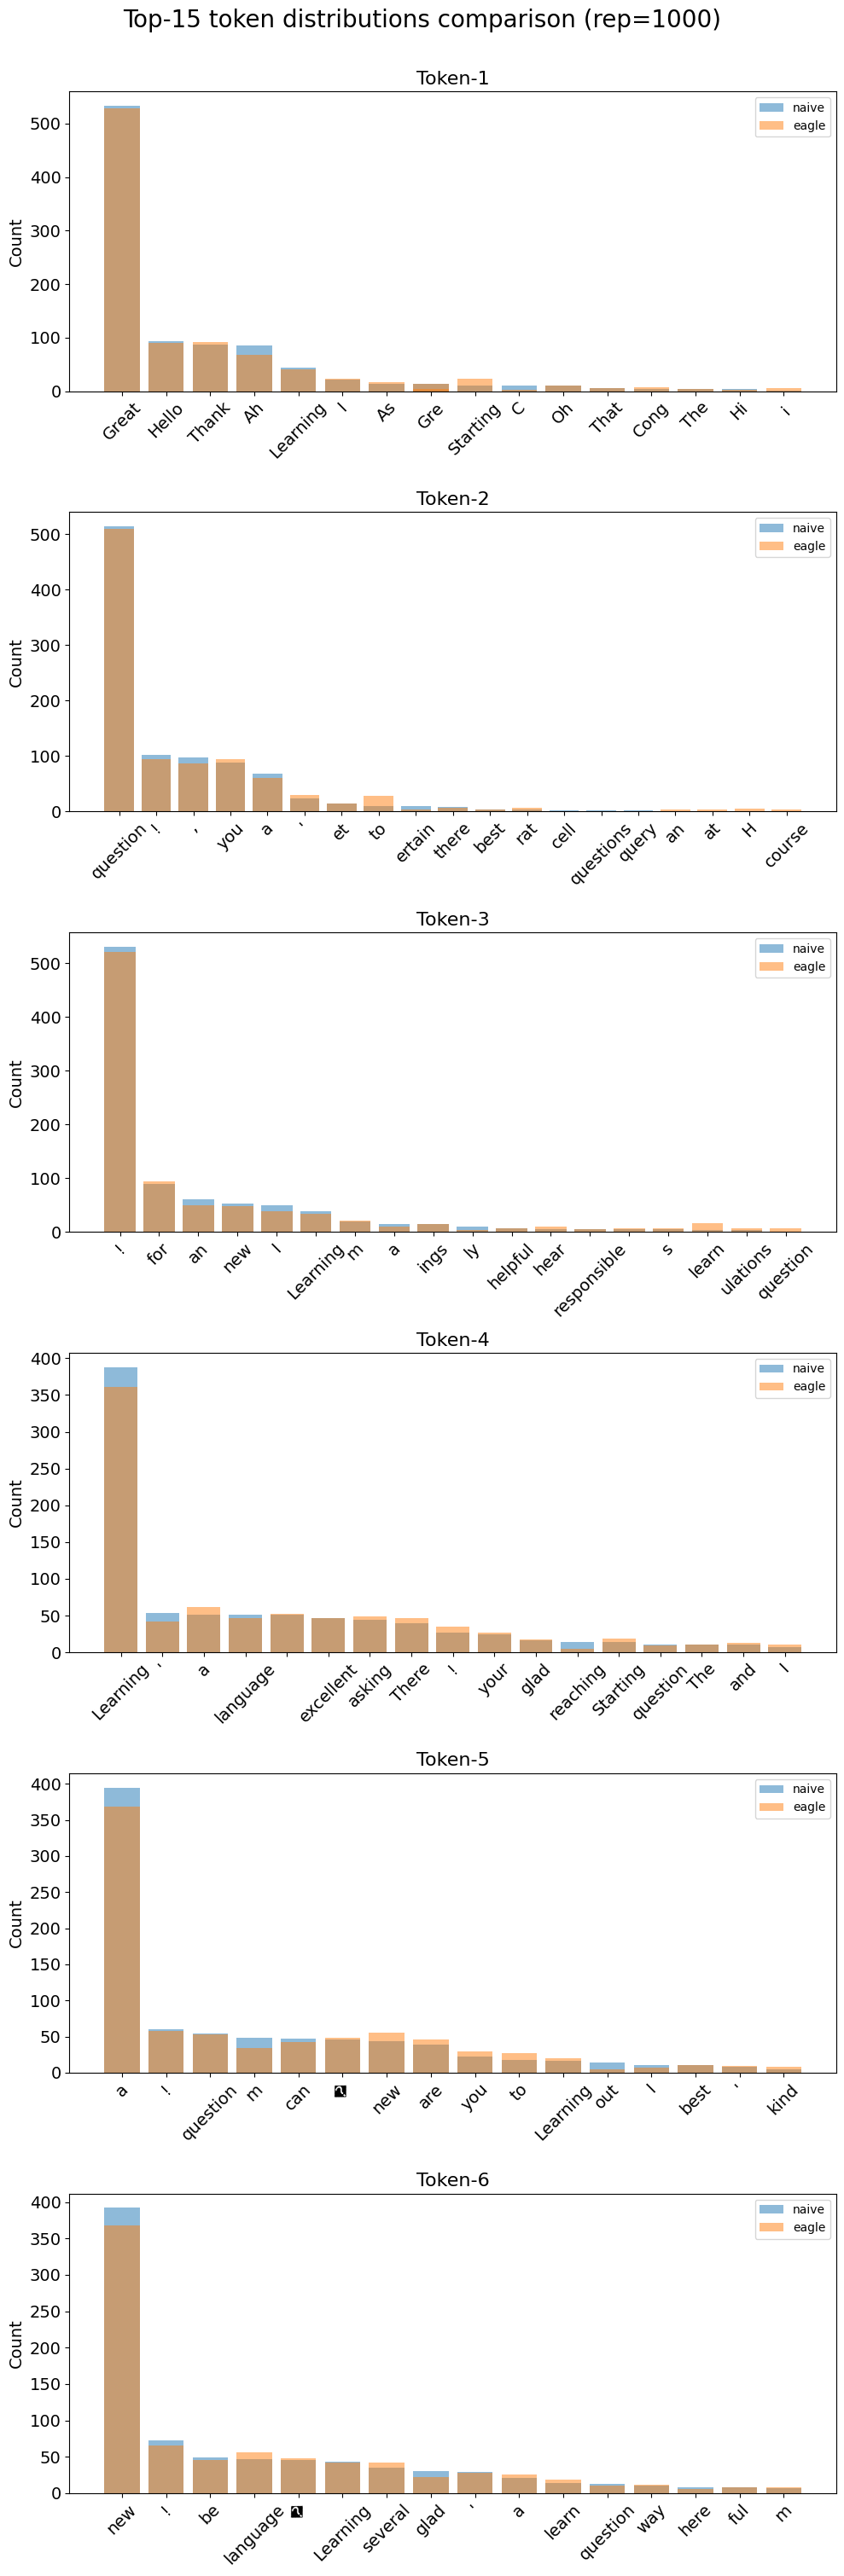

In [8]:
# Configurations
top_k = 15
labels = [
    "naive",
    "eagle"
]

union_samples_cnt_arr, tokens_str_arr = get_union_samples_cnts(samples_cnt_arr, comapre_tokens, top_k)
plot_topk_distribution(union_samples_cnt_arr, tokens_str_arr, comapre_tokens, top_k, labels)
plt.show()